In [3]:
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns

from pathlib import Path
from tqdm.autonotebook import tqdm
from sklearn.model_selection import train_test_split         # Split data into train and test set

from utils import get_df, evaluate_classifier

# Automatically prints execution time for the individual cells
%load_ext autotime

# Automatically reloads functions defined in external files
%load_ext autoreload
%autoreload 2

# Set xarray to use html as display_style
xr.set_options(display_style="html")

# Tell matplotlib to plot directly in the notebook
%matplotlib inline  

# The path to the project (so absoute file paths can be used throughout the notebook)
PROJ_PATH = Path.cwd().parent

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import sys


In [4]:
netcdf_path = (PROJ_PATH / 'data' / 'processed' / 'FieldPolygons2019_stats').with_suffix('.nc')
ds = xr.open_dataset(netcdf_path, engine="h5netcdf")
ds  # Remember to close the dataset before the netcdf file can be rewritten in cells above

<xarray.Dataset>
Dimensions:         (date: 77, field_id: 67312, polarization: 3)
Coordinates:
  * date            (date) datetime64[ns] 2018-07-08 2018-07-14 ... 2019-10-31
  * field_id        (field_id) int32 61853445 61952339 ... 62131272 63199619
  * polarization    (polarization) object 'VH' 'VV' 'VV-VH'
Data variables:
    afgkode         (field_id) int16 ...
    afgroede        (field_id) object ...
    cvr             (field_id) object ...
    gb              (field_id) float32 ...
    gbanmeldt       (field_id) float32 ...
    imk_areal       (field_id) float32 ...
    journalnr       (field_id) object ...
    marknr          (field_id) object ...
    pass_mode       (date) object ...
    relative_orbit  (date) int16 ...
    satellite       (date) object ...
    stats_max       (field_id, date, polarization) float32 ...
    stats_mean      (field_id, date, polarization) float32 ...
    stats_median    (field_id, date, polarization) float32 ...
    stats_min       (field_id, date, polarization) float32 ...
    stats_std       (field_id, date, polarization) float32 ...

time: 201 ms


In [5]:
ds.close()

time: 22.4 ms


In [6]:
# Convert the xarray dataset to pandas dataframe
df = ds.to_dataframe()
df = df.reset_index()  # Removes MultiIndex
df = df.drop(columns=['cvr', 'gb', 'gbanmeldt', 'journalnr', 'marknr', 'pass_mode', 'relative_orbit'])
df = df.dropna()

time: 11.4 s


In [7]:
# Create the df format to be used by scikit-learn
for i, polarization in enumerate(['VV', 'VH', 'VV-VH']):
    df_polarization = get_df(polygons_year=2019, 
                             satellite_dates=slice('2018-01-01', '2019-12-31'), 
                             fields='all', 
                             satellite='all', 
                             polarization=polarization,
                             netcdf_path=netcdf_path)
    
    # Extract a mapping of field_ids to crop type
    if i == 0:
        df_sklearn = df_polarization[['field_id', 'afgkode', 'afgroede']]
    
    # Pivot the df (https://stackoverflow.com/a/37790707/12045808)
    df_polarization = df_polarization.pivot(index='field_id', columns='date', values='stats_mean')
    
    # Add polarization to column names
    df_polarization.columns = [str(col)[:10]+f'_{polarization}' for col in df_polarization.columns]  
    
    # Merge the polarization dataframes into one dataframe
    df_polarization = df_polarization.reset_index()  # Creates new indices and a 'field_id' column (field id was used as indices before)
    df_sklearn = pd.merge(df_sklearn, df_polarization, on='field_id') 
        
# Drop fields having nan values
df_sklearn = df_sklearn.dropna()

# The merge operation for some reason made duplicates (there was a bug reported on this earlier), so drop duplicates and re-index the df
df_sklearn = df_sklearn.drop_duplicates().reset_index(drop=True)

time: 37.3 s


In [8]:
#df_sklearn

time: 21.5 ms


In [9]:
#df_sklearn[df_sklearn['afgkode'] == 252].describe()

time: 22.3 ms


In [10]:
df_sklearn = df_sklearn[df_sklearn['afgroede'].isin(['Vårbyg', 'Vinterhvede', 'Silomajs', 'Vinterraps', 
                                                     'Vinterbyg', 'Vårhavre', 'Vinterhybridrug'])]
crop_codes = df_sklearn['afgkode'].unique()
mapping_dict = {}
class_names = [] 

for i, crop_code in enumerate(crop_codes):
    mapping_dict[crop_code] = i
    crop_type = df_sklearn[df_sklearn['afgkode'] == crop_code].head(1)['afgroede'].values[0]
    class_names.append(crop_type)

df_sklearn_remapped = df_sklearn.copy()
df_sklearn_remapped['afgkode'] = df_sklearn_remapped['afgkode'].map(mapping_dict)
print(f"Crop types: {class_names}")

Crop types: ['Vårbyg', 'Vinterhvede', 'Silomajs', 'Vinterraps', 'Vinterbyg', 'Vårhavre', 'Vinterhybridrug']
time: 56.8 ms


In [11]:
array = df_sklearn_remapped.values

# Define the independent variables as features.
X = np.float32(array[:,3:])  # The features 

# Define the target (dependent) variable as labels.
y = np.int8(array[:,1])  # The column 'afgkode'

time: 556 ms


In [12]:
# Create a train/test split using 30% test size.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

print(f"Train samples:      {len(y_train)}")
print(f"Test samples:       {len(y_test)}")
print(f"Number of features: {len(X[0,:])}")

Train samples:      20729
Test samples:       8884
Number of features: 231
time: 70.4 ms


Training time: 23.6268 s
Prediction time: 0.0067 s

Report:

Train accuracy: 1.0
Test accuracy: 0.7027

                                           precision    recall  f1-score   support

                   Kartofler, stivelses-       0.85      0.84      0.85      1383
    Kartofler, lægge- (egen opformering)       0.37      0.34      0.36       223
                        Kartofler, andre       0.28      0.31      0.30       176
                       Kartofler, spise-       0.49      0.47      0.48       367
       Kartofler, lægge- (certificerede)       0.25      0.31      0.28       124
                                  Vårbyg       0.68      0.66      0.67      1162
                             Vinterhvede       0.85      0.81      0.83      1154
                                Silomajs       0.84      0.83      0.83      1436
                              Vinterraps       0.98      0.98      0.98      1091
                               Vinterbyg       0.90      0.90      0.90   

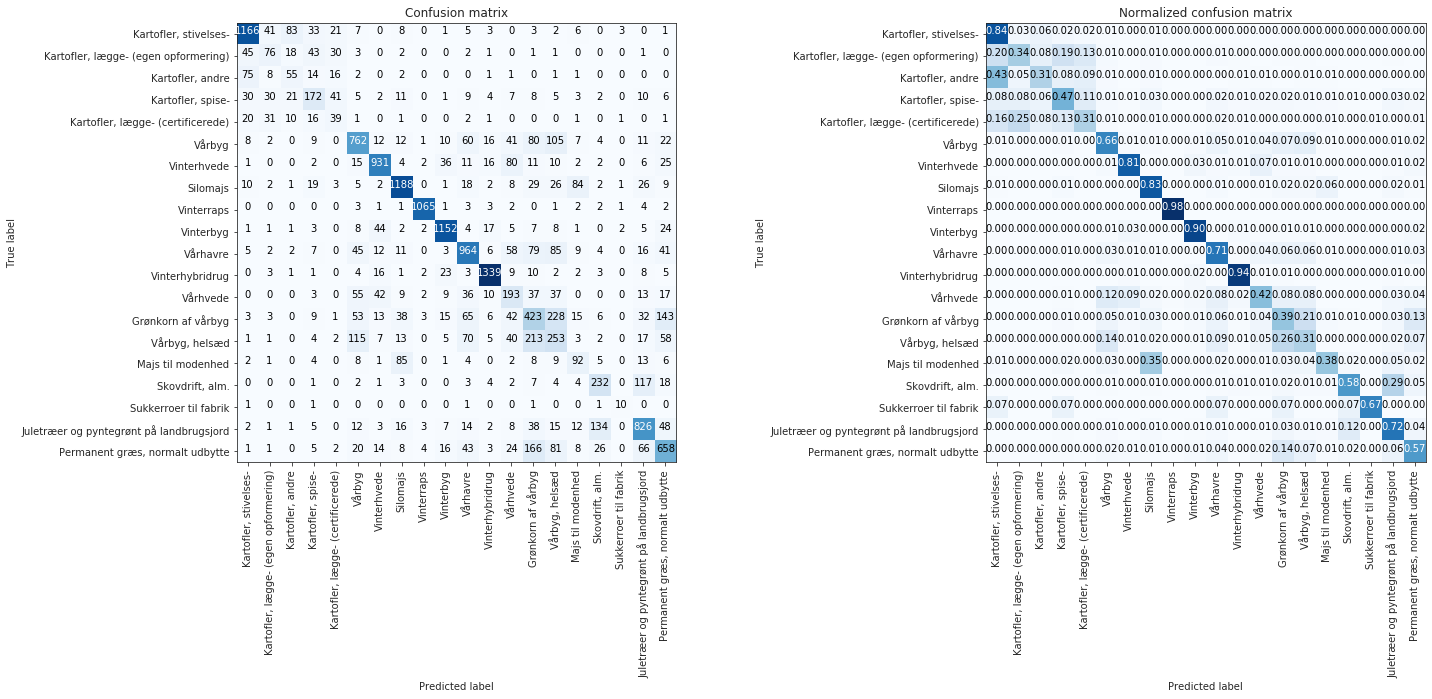

time: 26.4 s


In [11]:
from sklearn.tree import DecisionTreeClassifier              

# Instantiate and evaluate classifier
clf = DecisionTreeClassifier()
clf_trained = evaluate_classifier(clf, X_train, X_test, y_train, y_test, class_names,  feature_scale=False)

/opt/conda/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


Training time: 53.9072 s
Prediction time: 0.0065 s

Report:

Train accuracy: 0.8365
Test accuracy: 0.8174

                                           precision    recall  f1-score   support

                   Kartofler, stivelses-       0.86      0.94      0.90      1383
    Kartofler, lægge- (egen opformering)       0.54      0.41      0.47       223
                        Kartofler, andre       0.43      0.26      0.33       176
                       Kartofler, spise-       0.64      0.62      0.63       367
       Kartofler, lægge- (certificerede)       0.53      0.48      0.50       124
                                  Vårbyg       0.79      0.83      0.81      1162
                             Vinterhvede       0.93      0.94      0.94      1154
                                Silomajs       0.90      0.94      0.92      1436
                              Vinterraps       0.99      0.99      0.99      1091
                               Vinterbyg       0.97      0.98      0.98

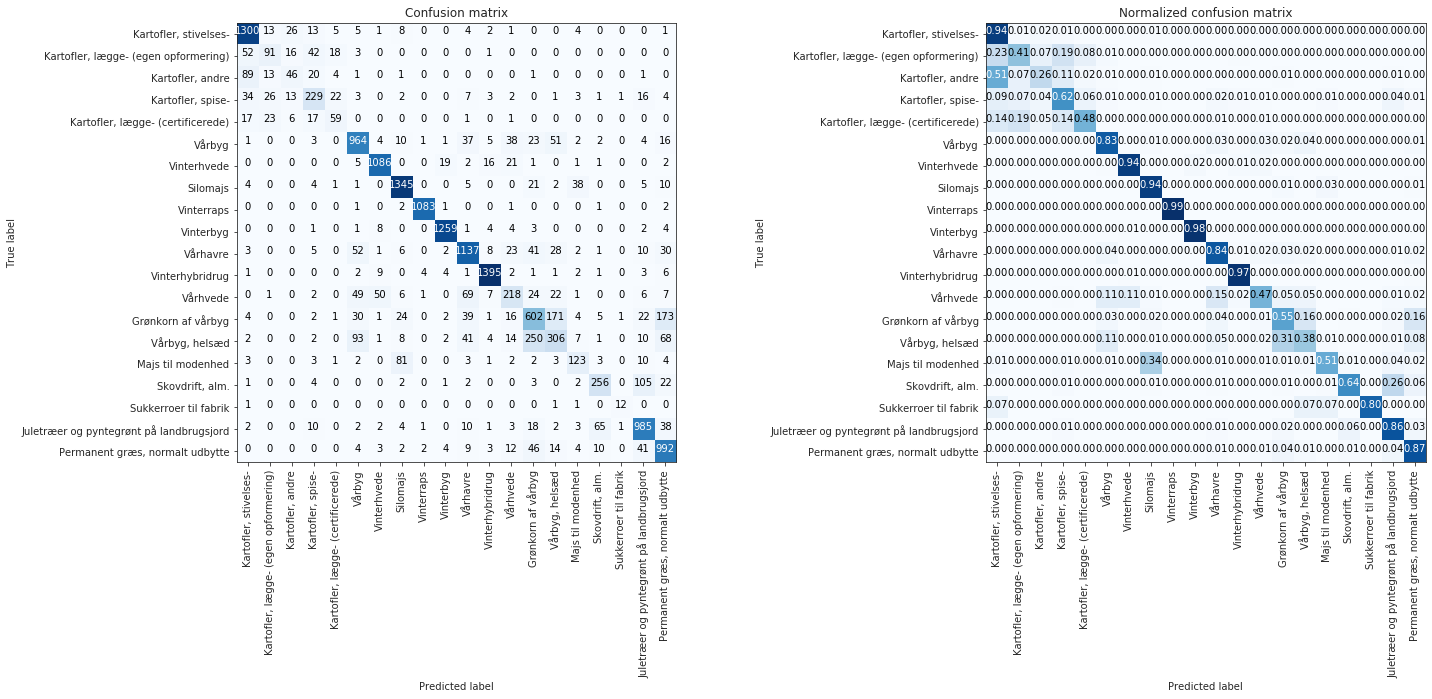

time: 56.9 s


In [12]:
from sklearn.linear_model import LogisticRegression          

# Instantiate classifier.
clf = LogisticRegression(solver='newton-cg', max_iter=1000)

# Evaluate classifier without feature scaling
clf_trained, _ = evaluate_classifier(clf, X_train, X_test, y_train, y_test, class_names, feature_scale=True)

/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Training time: 109.4168 s
Prediction time: 0.0182 s

Report:

Train accuracy: 0.8785
Test accuracy: 0.8151

                                           precision    recall  f1-score   support

                   Kartofler, stivelses-       0.87      0.92      0.90      1383
    Kartofler, lægge- (egen opformering)       0.50      0.35      0.41       223
                        Kartofler, andre       0.43      0.30      0.35       176
                       Kartofler, spise-       0.58      0.65      0.61       367
       Kartofler, lægge- (certificerede)       0.53      0.46      0.49       124
                                  Vårbyg       0.80      0.84      0.82      1162
                             Vinterhvede       0.93      0.94      0.93      1154
                                Silomajs       0.92      0.92      0.92      1436
                              Vinterraps       0.99      0.99      0.99      1091
                               Vinterbyg       0.97      0.97      0.9

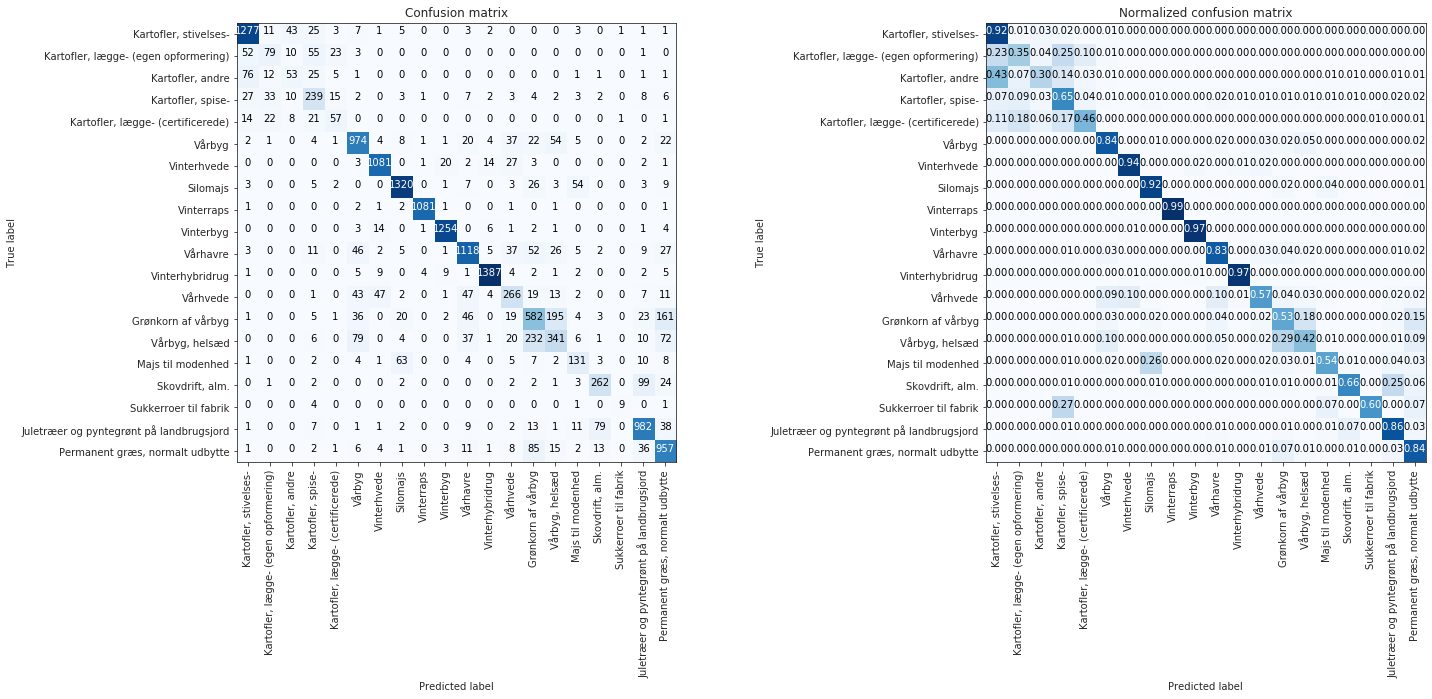

time: 1min 52s


In [13]:
from sklearn.neural_network import MLPClassifier

# Instantiate and evaluate classifier
clf = MLPClassifier(solver='lbfgs', alpha=10, hidden_layer_sizes=(25, 25), max_iter=1000)  # See what happens when you change random state
clf_trained = evaluate_classifier(clf, X_train, X_test, y_train, y_test, class_names, feature_scale=True)

Training time: 168.3291 s
Prediction time: 64.4148 s

Report:

Train accuracy: 0.8641
Test accuracy: 0.8158

                                           precision    recall  f1-score   support

                   Kartofler, stivelses-       0.86      0.94      0.90      1383
    Kartofler, lægge- (egen opformering)       0.50      0.44      0.47       223
                        Kartofler, andre       0.51      0.27      0.35       176
                       Kartofler, spise-       0.63      0.64      0.63       367
       Kartofler, lægge- (certificerede)       0.62      0.48      0.54       124
                                  Vårbyg       0.78      0.84      0.81      1162
                             Vinterhvede       0.91      0.94      0.93      1154
                                Silomajs       0.91      0.93      0.92      1436
                              Vinterraps       0.99      0.99      0.99      1091
                               Vinterbyg       0.96      0.97      0.

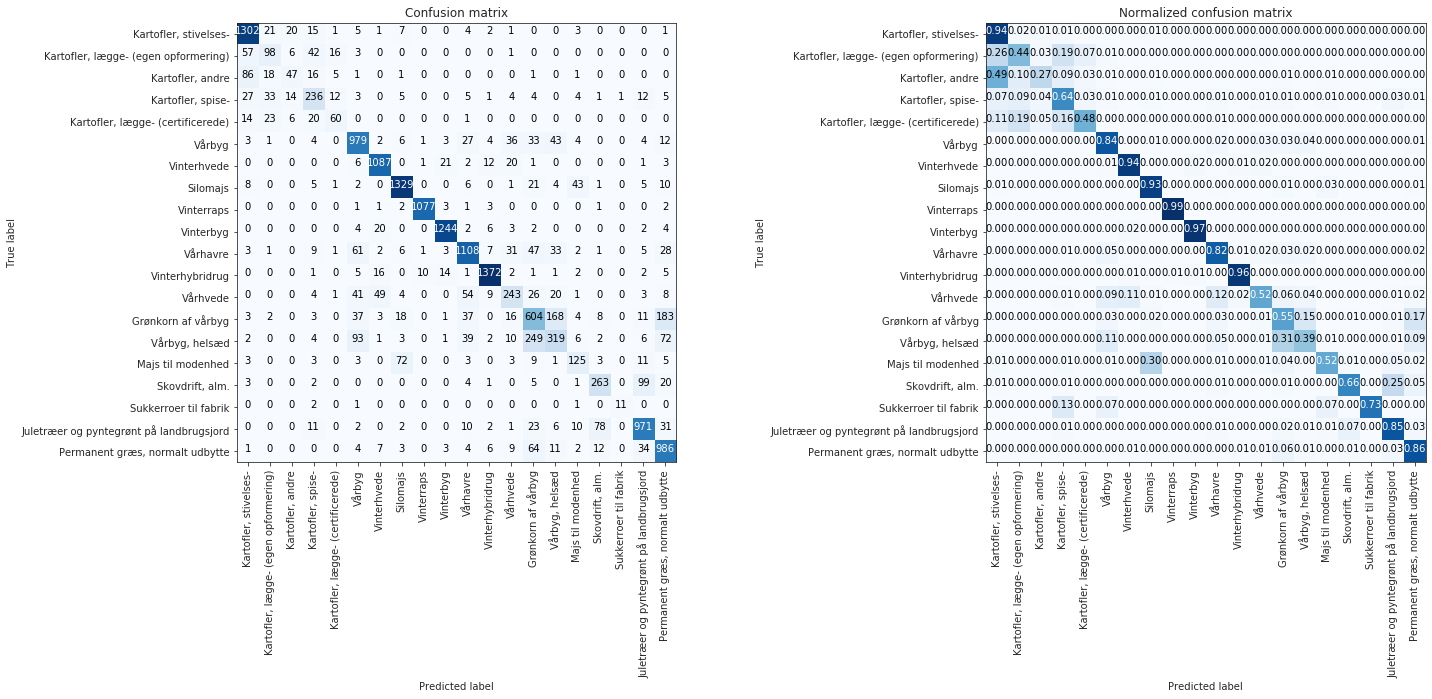

time: 7min 29s


In [14]:
from sklearn.svm import SVC   

# Instantiate and evaluate classifier
clf = SVC(kernel='linear')
clf_trained = evaluate_classifier(clf, X_train, X_test, y_train, y_test, class_names,  feature_scale=True)

Training time: 115.8309 s
Prediction time: 90.0276 s

Report:

Train accuracy: 0.8903
Test accuracy: 0.8467

                                           precision    recall  f1-score   support

                   Kartofler, stivelses-       0.85      0.97      0.90      1383
    Kartofler, lægge- (egen opformering)       0.55      0.50      0.53       223
                        Kartofler, andre       0.96      0.14      0.25       176
                       Kartofler, spise-       0.71      0.72      0.71       367
       Kartofler, lægge- (certificerede)       0.70      0.41      0.52       124
                                  Vårbyg       0.82      0.88      0.85      1162
                             Vinterhvede       0.94      0.96      0.95      1154
                                Silomajs       0.91      0.96      0.93      1436
                              Vinterraps       1.00      0.99      0.99      1091
                               Vinterbyg       0.99      0.98      0.

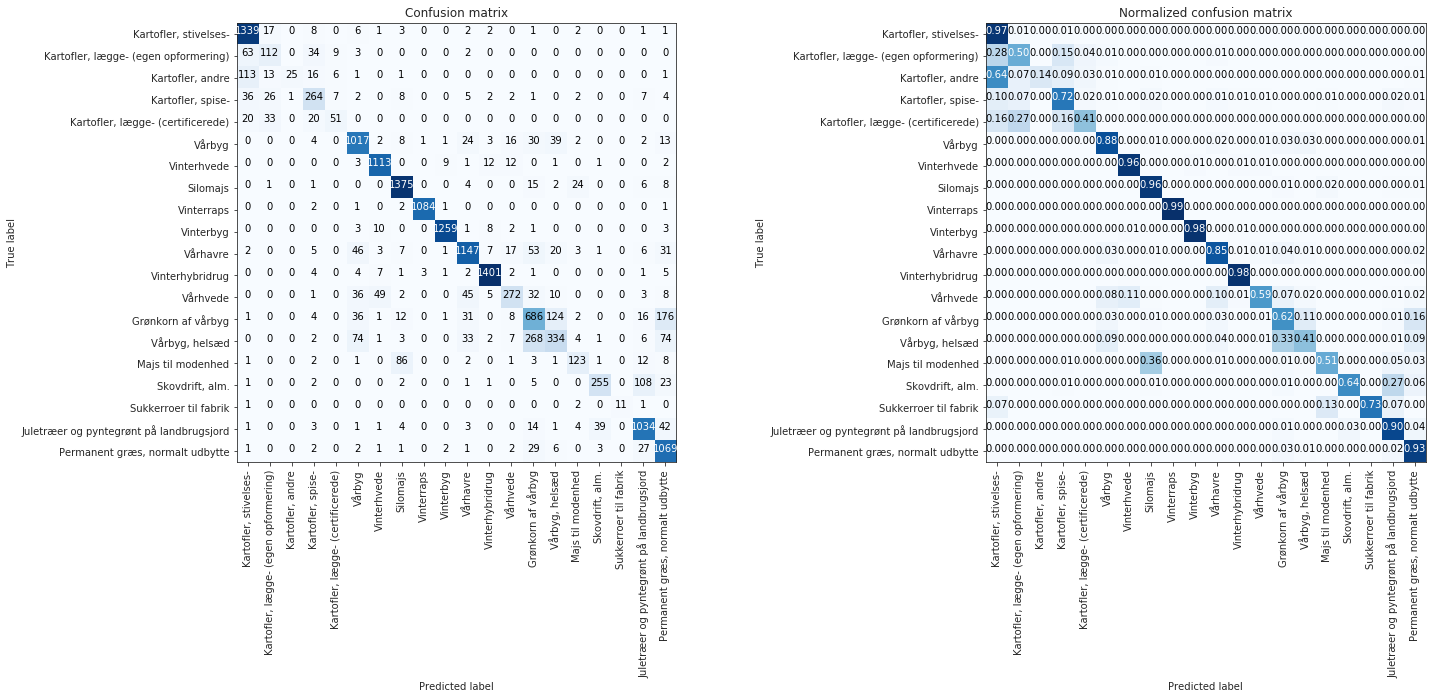

time: 8min 28s


In [15]:
# Instantiate and evaluate classifier
clf = SVC(kernel='rbf')
clf_trained = evaluate_classifier(clf, X_train, X_test, y_train, y_test, class_names,  feature_scale=True)

In [13]:
try:  # If auto-sklearn is installed 
    import autosklearn.classification
except:  # Else install auto-sklearn (https://automl.github.io/auto-sklearn/master/installation.html and https://hub.docker.com/r/alfranz/automl/dockerfile) 
    !sudo apt-get update && sudo apt-get install -y swig curl
    !curl https://raw.githubusercontent.com/automl/auto-sklearn/master/requirements.txt | xargs -n 1 -L 1 pip install --default-timeout=100
    !pip install auto-sklearn

time: 24.5 ms


In [ ]:
import autosklearn.classification

# Instantiate and evaluate classifier
clf = autosklearn.classification.AutoSklearnClassifier(time_left_for_this_task=1800, per_run_time_limit=360, 
                                                       ml_memory_limit=4096, n_jobs=24)
clf_trained = evaluate_classifier(clf, X_train, X_test, y_train, y_test, class_names,  feature_scale=True)

[WARNING] [2020-04-18 14:53:15,377:EnsembleBuilder(1791095845):b9324049020383802fc9cec230057637] No models better than random - using Dummy Score!
[WARNING] [2020-04-18 14:53:15,383:EnsembleBuilder(1791095845):b9324049020383802fc9cec230057637] No models better than random - using Dummy Score!
[WARNING] [2020-04-18 14:53:17,393:EnsembleBuilder(1791095845):b9324049020383802fc9cec230057637] No models better than random - using Dummy Score!
[WARNING] [2020-04-18 14:53:19,398:EnsembleBuilder(1791095845):b9324049020383802fc9cec230057637] No models better than random - using Dummy Score!


In [36]:
# https://automl.github.io/auto-sklearn/master/installation.html#installing-auto-sklearn
!sudo apt-get update
!sudo apt-get install -yy build-essential swig
!conda install -y gxx_linux-64 gcc_linux-64 swig
!curl https://raw.githubusercontent.com/automl/auto-sklearn/master/requirements.txt | xargs -n 1 -L 1 pip install
!pip install pyrfr==0.4.0
!pip install sklearn==0.21.3
!pip install auto-sklearn

Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic-updates InRelease                
Hit:3 http://archive.ubuntu.com/ubuntu bionic-backports InRelease              
Hit:4 http://security.ubuntu.com/ubuntu bionic-security InRelease              
Reading package lists... Done
Reading package lists... Done
Building dependency tree       
Reading state information... Done
build-essential is already the newest version (12.4ubuntu1).
swig is already the newest version (3.0.12-1).
0 upgraded, 0 newly installed, 0 to remove and 58 not upgraded.
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.7.12
  latest version: 4.8.3

Please update conda by running

    $ conda update -n base conda



# All requested packages already installed.

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   

In [42]:
#import autosklearn.classification

#clf = autosklearn.classification.AutoSklearnClassifier()
#clf_trained = evaluate_classifier(clf, X_train, X_test, y_train, y_test, class_names, feature_scale=False)
!pip install scikit-learn==0.22

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
  Using cached scikit_learn-0.22-cp37-cp37m-manylinux1_x86_64.whl (7.0 MB)
ERROR: smac 0.8.0 has requirement pyrfr>=0.5.0, but you'll have pyrfr 0.4.0 which is incompatible.
ERROR: auto-sklearn 0.6.0 has requirement pyrfr<0.9,>=0.7, but you'll have pyrfr 0.4.0 which is incompatible.
ERROR: auto-sklearn 0.6.0 has requirement scikit-learn<0.22,>=0.21.0, but you'll have scikit-learn 0.22 which is incompatible.
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.20.0
    Uninstalling scikit-learn-0.20.0:
      Successfully uninstalled scikit-learn-0.20.0
time: 4.38 s


In [2]:
try:  # If auto-sklearn is installed 
    import autosklearn.classification
except:  # Else install auto-sklearn (https://automl.github.io/auto-sklearn/master/installation.html and https://hub.docker.com/r/alfranz/automl/dockerfile) 
    !sudo apt-get update && sudo apt-get install -y swig curl
    !curl https://raw.githubusercontent.com/automl/auto-sklearn/master/requirements.txt | xargs -n 1 -L 1 pip install --default-timeout=100
    !pip install --default-timeout=100 auto-sklearn


import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics
X, y = sklearn.datasets.load_digits(return_X_y=True)
X_train, X_test, y_train, y_test = \
        sklearn.model_selection.train_test_split(X, y, random_state=1)
automl = autosklearn.classification.AutoSklearnClassifier(time_left_for_this_task=240, per_run_time_limit=20, 
                                                          ml_memory_limit=4096, n_jobs=16)
automl.fit(X_train, y_train)
y_hat = automl.predict(X_test)
print("Accuracy score", sklearn.metrics.accuracy_score(y_test, y_hat))

/opt/conda/lib/python3.7/site-packages/pyparsing.py:3174: FutureWarning: Possible set intersection at position 3
  self.re = re.compile(self.reString)


[WARNING] [2020-04-18 14:52:15,431:EnsembleBuilder(1791095845):d74860caaa557f473ce23908ff7ba369] No models better than random - using Dummy Score!
[WARNING] [2020-04-18 14:52:15,438:EnsembleBuilder(1791095845):d74860caaa557f473ce23908ff7ba369] No models better than random - using Dummy Score!


Process pynisher function call:
Process pynisher function call:
Process Process-13:
Process Process-1:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Process pynisher function call:
Traceback (most recent call last):
Traceback (most recent call last):
Process Process-11:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
Process Process-12:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process Process-2:
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/o

KeyboardInterrupt: 

KeyboardInterrupt
Process Process-15:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/autosklearn/estimators.py", line 15, in _fit_automl
    return automl.fit(load_models=load_models, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/autosklearn/automl.py", line 996, in fit
    load_models=load_models,
  File "/opt/conda/lib/python3.7/site-packages/autosklearn/automl.py", line 208, in fit
    only_return_configuration_space=only_return_configuration_space,
Process pynisher function call:
  File "/opt/conda/lib/python3.7/site-packages/autosklearn/automl.py", line 489, in _fit
    _proc_smac.run_smbo()
  File "/opt/conda/lib/python3.7/site-packages/autosklearn/smbo.py", line 504, in run_smbo
    smac.optimize()
  File "/opt/c

In [4]:
!sudo apt-get update && sudo apt-get install -y swig curl
!curl https://raw.githubusercontent.com/automl/auto-sklearn/master/requirements.txt | xargs -n 1 -L 1 pip install --default-timeout=100
!pip install --default-timeout=100 auto-sklearn

Hit:1 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree       
Reading state information... Done
swig is already the newest version (3.0.12-1).
curl is already the newest version (7.58.0-2ubuntu3.8).
0 upgraded, 0 newly installed, 0 to remove and 52 not upgraded.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   194  100   194    0     0   1577      0 --:--:-- --:--:-- --:--:--  1577
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Please see https://github.com/pyp

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Name: auto-sklearn
Version: 0.6.0
Summary: Automated machine learning.
Home-page: https://automl.github.io/auto-sklearn
Author: Matthias Feurer
Author-email: feurerm@informatik.uni-freiburg.de
License: BSD
Location: /opt/conda/lib/python3.7/site-packages
Requires: lockfile, psutil, scikit-learn, pyyaml, pyrfr, nose, joblib, ConfigSpace, pynisher, smac, liac-arff, setuptools, pandas, numpy, scipy, Cython
Required-by: 
